In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
import re
import pytz
import pandas_market_calendars as mcal
import time
import random
import yfinance as yf
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt

In [2]:
news_df = pd.read_csv("../data/preprocessed/analyst_ratings_processed.csv")

In [3]:
news_df.head(10)

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
5,5.0,"CFRA Maintains Hold on Agilent Technologies, L...",2020-05-22 11:23:00-04:00,A
6,6.0,"UBS Maintains Neutral on Agilent Technologies,...",2020-05-22 09:36:00-04:00,A
7,7.0,Agilent Technologies shares are trading higher...,2020-05-22 09:07:00-04:00,A
8,8.0,Wells Fargo Maintains Overweight on Agilent Te...,2020-05-22 08:37:00-04:00,A
9,9.0,10 Biggest Price Target Changes For Friday,2020-05-22 08:06:00-04:00,A


In [4]:
news_df = news_df.drop(columns=["Unnamed: 0"])

In [5]:
news_df.columns

Index(['title', 'date', 'stock'], dtype='object')

In [6]:
news_df.shape

(1400469, 3)

In [7]:
news_df.isna().sum()

title       0
date     1289
stock    2578
dtype: int64

In [8]:
news_df = news_df.dropna()
news_df.isna().sum()

title    0
date     0
stock    0
dtype: int64

In [9]:
for stock in news_df["stock"].unique():
    print(stock)


A
AAMC
AAME
AAN
AAOI
AAON
AAP
AAPL
AAU
AAV
AAVL
AAWW
AAXJ
AB
ABAC
ABAX
ABB
ABBV
ABC
ABCB
ABCD
ABCO
ABCW
ABDC
ABEV
ABG
ABGB
ABIO
ABM
ABMD
ABR
ABTL
ABX
ABY
ACAD
ACAS
ACAT
ACC
ACCO
ACCU
ACE
ACET
ACFC
ACFN
ACG
ACGL
ACH
ACHC
ACHN
ACIW
ACLS
ACM
ACMP
ACN
ACNB
ACOR
ACP
ACPW
ACRE
ACRX
ACSF
ACST
ACT
ACTA
ACTG
ACTS
ACU
ACUR
ACWI
ACWV
ACWX
ACXM
ACY
ADAT
ADBE
ADC
ADEP
ADES
ADGE
ADHD
ADI
ADK
ADM
ADMA
ADMP
ADMS
ADNC
ADP
ADPT
ADRA
ADRD
ADRE
ADRU
ADS
ADSK
ADT
ADTN
ADVS
ADX
ADXS
ADZ
AE
AEB
AEC
AEE
AEG
AEGN
AEGR
AEHR
AEIS
AEL
AEM
AEO
AEPI
AER
AERI
AES
AET
AETI
AEY
AEZS
AF
AFA
AFAM
AFB
AFC
AFCB
AFFX
AFG
AFH
AFK
AFL
AFMD
AFOP
AFSI
AFT
AG
AGA
AGC
AGCO
AGD
AGEN
AGF
AGG
AGII
AGIO
AGM
AGN
AGNC
AGNCB
AGND
AGO
AGOL
AGQ
AGRO
AGRX
AGTC
AGU
AGX
AGYS
AHC
AHGP
AHH
AHL
AHP
AHPI
AHT
AI
AIA
AIB
AIF
AIG
AIMC
AIN
AINC
AINV
AIQ
AIR
AIRM
AIRT
AIT
AIV
AIXG
AIZ
AJG
AKAM
AKAO
AKBA
AKER
AKG
AKP
AKR
AKRX
AKS
AL
ALB
ALCO
ALD
ALDR
ALDW
ALDX
ALE
ALEX
ALFA
ALG
ALGN
ALGT
ALIM
ALJ
ALK
ALKS
ALL
ALLB
ALLE
ALLT
ALLY
ALNY
ALOG
ALOT
ALQA
A

In [10]:
news_df.shape

(1397891, 3)

next cell is ai-generated

In [11]:
def get_us_exchange_map():
    nasdaq_url = "https://www.nasdaqtrader.com/dynamic/symdir/nasdaqlisted.txt"
    other_url  = "https://www.nasdaqtrader.com/dynamic/symdir/otherlisted.txt"

    # NASDAQ symbols
    nasdaq = pd.read_csv(nasdaq_url, sep="|", engine="python")
    nasdaq = nasdaq[~nasdaq["Symbol"].astype(str).str.startswith("File Creation Time", na=False)]
    nasdaq_map = pd.Series("NASDAQ", index=nasdaq["Symbol"])

    # NYSE symbols
    other = pd.read_csv(other_url, sep="|", engine="python")
    other = other[~other["ACT Symbol"].astype(str).str.startswith("File Creation Time", na=False)]
    nyse = other.loc[other["Exchange"] == "N", "ACT Symbol"]
    nyse_map = pd.Series("NYSE", index=nyse)

    # Combine (NASDAQ takes precedence if overlap)
    exchange_map = pd.concat([nasdaq_map, nyse_map]).groupby(level=0).first()

    return exchange_map

exchange_map = get_us_exchange_map()

news_df = news_df.copy()
news_df["exchange"] = news_df["stock"].map(exchange_map)

print(news_df["exchange"].value_counts(dropna=False))
print(news_df[news_df["exchange"].isna()]["stock"].unique()[:20])


exchange
NaN       595674
NYSE      477641
NASDAQ    324576
Name: count, dtype: int64
['AAMC' 'AAN' 'AAU' 'AAV' 'AAVL' 'AAWW' 'ABAC' 'ABAX' 'ABB' 'ABC' 'ABCD'
 'ABCO' 'ABCW' 'ABDC' 'ABGB' 'ABIO' 'ABMD' 'ABTL' 'ABY' 'ACAS']


In [12]:
news_df = news_df[news_df["exchange"].isin(["NYSE", "NASDAQ"])].copy()
news_df.reset_index(drop=True, inplace=True)
print(news_df["exchange"].value_counts())
assert news_df["exchange"].isna().sum() == 0


exchange
NYSE      477641
NASDAQ    324576
Name: count, dtype: int64


In [13]:
US_EASTERN = pytz.timezone("US/Eastern")

def add_us_windows(news_df, ts_col="timestamp"):
    df = news_df.copy()
    ts = pd.to_datetime(df[ts_col], utc=True).dt.tz_convert(US_EASTERN)
    df["timestamp_et"] = ts
    df["time_et"] = ts.dt.time
    df["date_et"] = ts.dt.normalize().dt.date

    t = ts.dt.hour * 60 + ts.dt.minute  # minutes since midnight

    INTRADAY_START = 9 * 60 + 30   # 09 30
    INTRADAY_END   = 16 * 60       # 16 00
    AFTER_END      = 20 * 60       # 20 00

    df["news_window"] = np.select(
        [
            (t >= INTRADAY_START) & (t < INTRADAY_END),
            (t >= INTRADAY_END) & (t < AFTER_END),
            (t < INTRADAY_START) | (t >= AFTER_END),
        ],
        ["intraday", "after_close", "overnight"],
        default="overnight",
    )

    return df


news_df = add_us_windows(news_df, ts_col="date")
news_df["news_window"].value_counts()


news_window
overnight      362257
intraday       323606
after_close    116354
Name: count, dtype: int64

In [14]:
news_df = news_df.sort_values("date", ascending=False).reset_index(drop=True)

news_df.head(50)

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window
0,Quicken Loans Plans To IPO: Report,2020-06-11 17:12:00-04:00,WFC,NYSE,2020-06-11 17:12:00-04:00,17:12:00,2020-06-11,after_close
1,PG&E Corp Reports CPUC Approved Co.'s Microgri...,2020-06-11 17:11:00-04:00,PCG,NYSE,2020-06-11 17:11:00-04:00,17:11:00,2020-06-11,after_close
2,"Financials, Energy Among Worst-Hit Sectors In ...",2020-06-11 16:51:00-04:00,WMT,NASDAQ,2020-06-11 16:51:00-04:00,16:51:00,2020-06-11,after_close
3,7 Stocks Moving In Thursday's After-Hours Session,2020-06-11 16:49:00-04:00,PVH,NYSE,2020-06-11 16:49:00-04:00,16:49:00,2020-06-11,after_close
4,W. P. Carey Inc. Increases Quarterly Dividend ...,2020-06-11 16:30:00-04:00,WPC,NYSE,2020-06-11 16:30:00-04:00,16:30:00,2020-06-11,after_close
5,PVH shares are trading lower after the company...,2020-06-11 16:25:00-04:00,PVH,NYSE,2020-06-11 16:25:00-04:00,16:25:00,2020-06-11,after_close
6,PVH: Q1 Earnings Insights,2020-06-11 16:24:00-04:00,PVH,NYSE,2020-06-11 16:24:00-04:00,16:24:00,2020-06-11,after_close
7,PVH Q1 Adj. EPS $(3.03) Misses $(1.28) Estimat...,2020-06-11 16:15:00-04:00,PVH,NYSE,2020-06-11 16:15:00-04:00,16:15:00,2020-06-11,after_close
8,Why Tyson Foods Stock Is Trading Lower Today,2020-06-11 15:32:00-04:00,TSN,NYSE,2020-06-11 15:32:00-04:00,15:32:00,2020-06-11,intraday
9,An ETF Play On Laggard Stocks,2020-06-11 15:25:00-04:00,WMT,NASDAQ,2020-06-11 15:25:00-04:00,15:25:00,2020-06-11,intraday


I will not split stocks into separate datasets, I will keep them as one. The model will learn stock-specific effects via features.

In [15]:
news_df.nunique()

title           510727
date            441690
stock             2488
exchange             2
timestamp_et    441690
time_et           1440
date_et           3907
news_window          3
dtype: int64

below cell is generated with ai 

In [16]:
ETF_TO_SECTOR = {
    "XLE":  "Energy",
    "XLF":  "Financials",
    "XLK":  "Technology",
    "XLV":  "Health Care",
    "XLY":  "Consumer Discretionary",

    "XLI":  "Industrials",
    "XLP":  "Consumer Staples",
    "XLU":  "Utilities",
    "XLB":  "Materials",
    "XLC":  "Communication Services",
    "XLRE": "Real Estate",
}

HOLDINGS_XLSX = {
    "XLE":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xle.xlsx",
    "XLF":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlf.xlsx",
    "XLK":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlk.xlsx",
    "XLV":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlv.xlsx",
    "XLY":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xly.xlsx",

    "XLI":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xli.xlsx",
    "XLP":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlp.xlsx",
    "XLU":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlu.xlsx",
    "XLB":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlb.xlsx",
    "XLC":  "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlc.xlsx",
    "XLRE": "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-xlre.xlsx",
}


def _find_best_ticker_col(df: pd.DataFrame) -> str | None:
    """
    Try to detect which column contains tickers/symbols.
    Works even if the file has extra columns or slightly different names.
    """
    cols = {c.lower(): c for c in df.columns}

    # common names first
    for key in ["ticker", "symbol", "holding ticker", "identifier", "security id"]:
        if key in cols:
            return cols[key]

    # heuristic fallback: pick a column with lots of ticker-like strings
    ticker_re = re.compile(r"^[A-Z]{1,6}([.\-][A-Z0-9]{1,4})?$")  # e.g. BRK.B or BF-B
    best = None
    best_score = 0

    for c in df.columns:
        s = df[c].astype(str).str.strip()
        score = s.map(lambda x: bool(ticker_re.match(x))).mean()
        if score > best_score:
            best_score = score
            best = c

    return best if best_score >= 0.20 else None  # require at least some signal

def _find_weight_col(df: pd.DataFrame) -> str | None:
    cols = {c.lower(): c for c in df.columns}
    for key in ["weight", "weight (%)", "portfolio weight", "market value weight"]:
        if key in cols:
            return cols[key]
    # heuristic: any column containing "weight"
    for c in df.columns:
        if "weight" in str(c).lower():
            return c
    return None

def load_ssga_holdings(etf: str) -> pd.DataFrame:
    """
    Download + parse an SSGA holdings xlsx into a tidy df: [stock, etf, weight]
    Tries multiple skiprows because SSGA files can have header text above the table.
    """
    url = HOLDINGS_XLSX[etf]

    last_err = None
    for skip in range(0, 25):
        try:
            tmp = pd.read_excel(url, sheet_name=0, skiprows=skip)
            tmp = tmp.dropna(axis=1, how="all")
            if tmp.shape[1] < 2:
                continue

            ticker_col = _find_best_ticker_col(tmp)
            if ticker_col is None:
                continue

            weight_col = _find_weight_col(tmp)

            out = pd.DataFrame({
                "stock": tmp[ticker_col].astype(str).str.strip(),
            })
            out["etf"] = etf

            if weight_col is not None:
                # convert weights robustly (handles "2.34%" strings too)
                w = tmp[weight_col].astype(str).str.replace("%", "", regex=False).str.strip()
                out["weight"] = pd.to_numeric(w, errors="coerce")
            else:
                out["weight"] = pd.NA

            # keep only ticker-like rows
            out = out[out["stock"].str.match(r"^[A-Z]{1,6}([.\-][A-Z0-9]{1,4})?$", na=False)]
            out = out.dropna(subset=["stock"]).drop_duplicates(subset=["stock"])
            if len(out) > 10:  # sanity check: holdings should not be tiny
                return out.reset_index(drop=True)

        except Exception as e:
            last_err = e
            continue

    raise RuntimeError(f"Could not parse holdings for {etf}. Last error: {last_err}")

def build_stock_to_sector_map() -> pd.DataFrame:
    """
    Returns mapping table: [stock, sector, etf, weight]
    If a stock appears in multiple ETFs, picks the row with max weight (if available),
    otherwise keeps the first occurrence.
    """
    all_holdings = []
    for etf in ETF_TO_SECTOR:
        h = load_ssga_holdings(etf)
        h["sector"] = ETF_TO_SECTOR[etf]
        all_holdings.append(h)

    holdings = pd.concat(all_holdings, ignore_index=True)

    # prefer highest weight if weights exist
    if holdings["weight"].notna().any():
        holdings = holdings.sort_values(["stock", "weight"], ascending=[True, False])
    else:
        holdings = holdings.sort_values(["stock", "etf"])

    mapping = holdings.drop_duplicates(subset=["stock"], keep="first").reset_index(drop=True)
    return mapping[["stock", "sector", "etf", "weight"]]

# ---- USAGE on your news_df ----
# news_df has column "stock"
stock_sector_map = build_stock_to_sector_map()

news_df = news_df.merge(stock_sector_map[["stock", "sector"]], on="stock", how="left")
news_df["sector"] = news_df["sector"].fillna("Other")

# sanity check
print(news_df["sector"].value_counts(dropna=False).head(20))


sector
Other                     473228
Technology                 51945
Health Care                49835
Financials                 46624
Industrials                41288
Consumer Discretionary     40327
Consumer Staples           30120
Communication Services     17832
Materials                  15173
Energy                     14182
Utilities                  13204
Real Estate                 8459
Name: count, dtype: int64


In [17]:
news_df.groupby("sector")["stock"].nunique().sort_values(ascending=False)

sector
Other                     2103
Financials                  60
Industrials                 59
Technology                  56
Health Care                 49
Consumer Discretionary      39
Consumer Staples            28
Utilities                   22
Real Estate                 21
Materials                   18
Energy                      17
Communication Services      16
Name: stock, dtype: int64

In [18]:
news_df.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector
0,Quicken Loans Plans To IPO: Report,2020-06-11 17:12:00-04:00,WFC,NYSE,2020-06-11 17:12:00-04:00,17:12:00,2020-06-11,after_close,Financials
1,PG&E Corp Reports CPUC Approved Co.'s Microgri...,2020-06-11 17:11:00-04:00,PCG,NYSE,2020-06-11 17:11:00-04:00,17:11:00,2020-06-11,after_close,Utilities
2,"Financials, Energy Among Worst-Hit Sectors In ...",2020-06-11 16:51:00-04:00,WMT,NASDAQ,2020-06-11 16:51:00-04:00,16:51:00,2020-06-11,after_close,Consumer Staples
3,7 Stocks Moving In Thursday's After-Hours Session,2020-06-11 16:49:00-04:00,PVH,NYSE,2020-06-11 16:49:00-04:00,16:49:00,2020-06-11,after_close,Other
4,W. P. Carey Inc. Increases Quarterly Dividend ...,2020-06-11 16:30:00-04:00,WPC,NYSE,2020-06-11 16:30:00-04:00,16:30:00,2020-06-11,after_close,Other


New columns


trading_date
This is not the article date, but the trading day to which this article belongs for labeling.

Rules:
intraday → same day (if trading day)

overnight → same day (if trading day)

after_close → next trading day

below cell is generated with ai

In [19]:
nyse = mcal.get_calendar("NYSE")

def add_is_trading_day_and_trading_date(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    article_date = pd.to_datetime(df["timestamp_et"].dt.date)

    start = article_date.min() - pd.Timedelta(days=7)
    end   = article_date.max() + pd.Timedelta(days=14)
    sched = nyse.schedule(start_date=start, end_date=end)
    trading_days = pd.DatetimeIndex(sched.index).normalize()

    df["is_trading_day"] = article_date.isin(trading_days).to_numpy()

    pos_next = trading_days.searchsorted(article_date.values, side="right")
    next_td = trading_days.take(np.minimum(pos_next, len(trading_days)-1))
    next_td_date = next_td.date

    df["trading_date"] = next_td_date

    same_day_mask = df["is_trading_day"] & df["news_window"].isin(["intraday", "overnight"])
    df.loc[same_day_mask, "trading_date"] = article_date[same_day_mask].dt.date

    return df

news_df = add_is_trading_day_and_trading_date(news_df)


In [20]:
news_df[["date", "timestamp_et", "news_window", "trading_date"]].head(10000)

,date,timestamp_et,news_window,trading_date
0,2020-06-11 17:12:00-04:00,2020-06-11 17:12:00-04:00,after_close,2020-06-12
1,2020-06-11 17:11:00-04:00,2020-06-11 17:11:00-04:00,after_close,2020-06-12
2,2020-06-11 16:51:00-04:00,2020-06-11 16:51:00-04:00,after_close,2020-06-12
3,2020-06-11 16:49:00-04:00,2020-06-11 16:49:00-04:00,after_close,2020-06-12
4,2020-06-11 16:30:00-04:00,2020-06-11 16:30:00-04:00,after_close,2020-06-12
...,...,...,...,...
9995,2020-05-17 19:07:00-04:00,2020-05-17 19:07:00-04:00,after_close,2020-05-18
9996,2020-05-17 19:07:00-04:00,2020-05-17 19:07:00-04:00,after_close,2020-05-18
9997,2020-05-17 13:00:00-04:00,2020-05-17 13:00:00-04:00,intraday,2020-05-18
9998,2020-05-17 13:00:00-04:00,2020-05-17 13:00:00-04:00,intraday,2020-05-18


In [21]:
news_df["articles_same_stock_day"] = news_df.groupby(["stock", "trading_date"])["stock"].transform("size")
news_df["articles_same_sector_day"] = news_df.groupby(["sector", "trading_date"])["sector"].transform("size")


In [22]:
tmp = news_df.copy()
tmp["article_date"] = news_df["timestamp_et"].dt.date
assert (pd.to_datetime(tmp["trading_date"]) >= pd.to_datetime(tmp["article_date"])).all()

pd.crosstab(news_df["news_window"],
            news_df["timestamp_et"].dt.date == news_df["trading_date"])



col_0,False,True
news_window,,
after_close,116354,0
intraday,7529,316077
overnight,3727,358530


In [23]:
news_df.to_csv("../data/preprocessed/news_separate_stocks.csv", index=False)
#news_df.to_parquet("../data/preprocessed/news_separate_stocks.parquet", index=False)

In [24]:
news_df.head(20)

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,trading_date,articles_same_stock_day,articles_same_sector_day
0,Quicken Loans Plans To IPO: Report,2020-06-11 17:12:00-04:00,WFC,NYSE,2020-06-11 17:12:00-04:00,17:12:00,2020-06-11,after_close,Financials,True,2020-06-12,1,1
1,PG&E Corp Reports CPUC Approved Co.'s Microgri...,2020-06-11 17:11:00-04:00,PCG,NYSE,2020-06-11 17:11:00-04:00,17:11:00,2020-06-11,after_close,Utilities,True,2020-06-12,1,1
2,"Financials, Energy Among Worst-Hit Sectors In ...",2020-06-11 16:51:00-04:00,WMT,NASDAQ,2020-06-11 16:51:00-04:00,16:51:00,2020-06-11,after_close,Consumer Staples,True,2020-06-12,1,1
3,7 Stocks Moving In Thursday's After-Hours Session,2020-06-11 16:49:00-04:00,PVH,NYSE,2020-06-11 16:49:00-04:00,16:49:00,2020-06-11,after_close,Other,True,2020-06-12,4,5
4,W. P. Carey Inc. Increases Quarterly Dividend ...,2020-06-11 16:30:00-04:00,WPC,NYSE,2020-06-11 16:30:00-04:00,16:30:00,2020-06-11,after_close,Other,True,2020-06-12,1,5
5,PVH shares are trading lower after the company...,2020-06-11 16:25:00-04:00,PVH,NYSE,2020-06-11 16:25:00-04:00,16:25:00,2020-06-11,after_close,Other,True,2020-06-12,4,5
6,PVH: Q1 Earnings Insights,2020-06-11 16:24:00-04:00,PVH,NYSE,2020-06-11 16:24:00-04:00,16:24:00,2020-06-11,after_close,Other,True,2020-06-12,4,5
7,PVH Q1 Adj. EPS $(3.03) Misses $(1.28) Estimat...,2020-06-11 16:15:00-04:00,PVH,NYSE,2020-06-11 16:15:00-04:00,16:15:00,2020-06-11,after_close,Other,True,2020-06-12,4,5
8,Why Tyson Foods Stock Is Trading Lower Today,2020-06-11 15:32:00-04:00,TSN,NYSE,2020-06-11 15:32:00-04:00,15:32:00,2020-06-11,intraday,Consumer Staples,True,2020-06-11,5,23
9,An ETF Play On Laggard Stocks,2020-06-11 15:25:00-04:00,WMT,NASDAQ,2020-06-11 15:25:00-04:00,15:25:00,2020-06-11,intraday,Consumer Staples,True,2020-06-11,4,23


In [25]:
news_df.columns

Index(['title', 'date', 'stock', 'exchange', 'timestamp_et', 'time_et',
       'date_et', 'news_window', 'sector', 'is_trading_day', 'trading_date',
       'articles_same_stock_day', 'articles_same_sector_day'],
      dtype='object')

In [26]:
print(news_df["date"].min())
print(news_df["date"].max())

2009-04-27 14:39:00-04:00
2020-06-11 17:12:00-04:00


In [27]:
CORE_SECTORS = [
    "Technology",
    "Health Care",
    "Financials",
    "Industrials",
    "Consumer Discretionary",
    "Consumer Staples",
    "Energy",
    "Utilities",
    "Materials",
    "Communication Services",
    "Real Estate",
]

news_core = news_df[news_df["sector"].isin(CORE_SECTORS)].copy()
news_core.reset_index(drop=True, inplace=True)

print("Articles:", len(news_core))
print("Tickers:", news_core["stock"].nunique())
print(news_core["sector"].value_counts())


Articles: 328989
Tickers: 385
sector
Technology                51945
Health Care               49835
Financials                46624
Industrials               41288
Consumer Discretionary    40327
Consumer Staples          30120
Communication Services    17832
Materials                 15173
Energy                    14182
Utilities                 13204
Real Estate                8459
Name: count, dtype: int64


In [28]:
core_tickers = sorted(news_core["stock"].unique())
print(len(core_tickers), "core tickers")


385 core tickers


below cell is generated with ai 

In [29]:
START = "2009-03-25"
END   = "2020-07-14"
CHUNK_SIZE = 50
SLEEP_BETWEEN_CHUNKS = (2.0, 6.0)

OUT_DIR = Path("../data/yahoo_prices")
OUT_DIR.mkdir(parents=True, exist_ok=True)


def chunked(iterable, size):
    iterable = list(iterable)
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]


def download_close_chunk(tickers, start=START, end=END, prefer_adj=True):
    """
    Download one chunk of tickers from Yahoo Finance.
    Returns DataFrame indexed by date, columns=tickers, values=Adj Close (preferred) or Close.
    """

    tickers = list(tickers)
    tickers_str = " ".join(tickers)

    df = yf.download(
        tickers=tickers_str,
        start=start,
        end=end,
        group_by="column",
        auto_adjust=False,   # keep Adj Close available
        threads=True,
        progress=False,
    )

    if df is None or df.empty:
        return pd.DataFrame()

    # --- Multi-ticker case ---
    if isinstance(df.columns, pd.MultiIndex):
        fields = df.columns.get_level_values(0)
        field = "Adj Close" if prefer_adj and ("Adj Close" in fields) else "Close"
        close = df[field].copy()

    # --- Single ticker case ---
    else:
        field = "Adj Close" if prefer_adj and ("Adj Close" in df.columns) else "Close"
        s = df[field].copy()            # Series
        close = s.to_frame(name=tickers[0])

    # Clean index (daily, naive)
    close.index = pd.to_datetime(close.index).tz_localize(None)

    # Drop duplicate columns if Yahoo returned weird overlaps
    close = close.loc[:, ~close.columns.duplicated()].copy()

    return close


def download_all_close_prices(
    tickers,
    chunk_size=CHUNK_SIZE,
    start=START,
    end=END,
    out_dir=OUT_DIR,
    resume=True
):
    """
    Download Adj Close prices for all tickers in chunks.
    Saves each chunk to disk and concatenates into one wide matrix.
    """

    tickers = sorted(set(tickers))
    chunks = list(chunked(tickers, chunk_size))

    all_parts = []

    for k, tchunk in enumerate(chunks, start=1):
        cache_path = out_dir / f"adjclose_chunk_{k:03d}.parquet"

        if resume and cache_path.exists():
            part = pd.read_parquet(cache_path)
            part.index = pd.to_datetime(part.index)
            all_parts.append(part)
            print(f"[{k}/{len(chunks)}] loaded cache {cache_path.name} {part.shape}")
            continue

        print(f"[{k}/{len(chunks)}] downloading {len(tchunk)} tickers…")

        try:
            part = download_close_chunk(tchunk, start=start, end=end)
            part.to_parquet(cache_path)
            all_parts.append(part)

            print(f"    saved {cache_path.name} {part.shape}")
            time.sleep(random.uniform(*SLEEP_BETWEEN_CHUNKS))

        except Exception as e:
            print(f"    ERROR in chunk {k}: {e}")
            time.sleep(10 + random.uniform(0, 5))

    if not all_parts:
        return pd.DataFrame()

    # Combine all chunks
    close_all = pd.concat(all_parts, axis=1)
    close_all = close_all.loc[:, ~close_all.columns.duplicated()]
    close_all = close_all.sort_index()

    # Drop completely empty tickers (Yahoo failures)
    close_all = close_all.dropna(axis=1, how="all")

    out_path = out_dir / "adjclose_all.parquet"
    close_all.to_parquet(out_path)

    print(f"FINAL saved: {out_path}")
    print("Shape:", close_all.shape)

    return close_all

tickers = news_core["stock"].dropna().astype(str).unique().tolist()
close_all = download_all_close_prices(tickers)

print("Tickers requested:", len(tickers))
print("Tickers downloaded:", close_all.shape[1])
print("Date range:", close_all.index.min(), "→", close_all.index.max())

missing = sorted(set(tickers) - set(close_all.columns))
print("Missing tickers:", len(missing))
print("Examples:", missing[:20])



[1/8] loaded cache adjclose_chunk_001.parquet (2845, 50)
[2/8] loaded cache adjclose_chunk_002.parquet (2845, 50)
[3/8] loaded cache adjclose_chunk_003.parquet (2845, 50)
[4/8] loaded cache adjclose_chunk_004.parquet (2845, 50)
[5/8] loaded cache adjclose_chunk_005.parquet (2845, 50)
[6/8] loaded cache adjclose_chunk_006.parquet (2845, 50)
[7/8] loaded cache adjclose_chunk_007.parquet (2845, 50)
[8/8] loaded cache adjclose_chunk_008.parquet (2845, 35)
FINAL saved: ..\data\yahoo_prices\adjclose_all.parquet
Shape: (2845, 381)
Tickers requested: 385
Tickers downloaded: 381
Date range: 2009-03-25 00:00:00 → 2020-07-13 00:00:00
Missing tickers: 4
Examples: ['APP', 'EXE', 'Q', 'SNDK']


In [30]:
missing = ['APP', 'EXE', 'Q', 'SNDK']
news_core = news_core[~news_core["stock"].isin(missing)].copy()
print("Tickers after drop:", news_core["stock"].nunique())


Tickers after drop: 381


In [31]:
na_share = close_all.isna().mean().sort_values(ascending=False)
print("Worst 20 tickers by NaN share:")
print(na_share.head(20))

BAD = na_share[na_share > 0.50].index.tolist()  # x>50% missing days
print("Tickers with >50% missing:", len(BAD))


Worst 20 tickers by NaN share:
Ticker
DOW     0.883304
FOX     0.881547
FOXA    0.881195
IR      0.719859
KEYS    0.493146
CFG     0.486819
ANET    0.460105
ARES    0.451670
PAYC    0.447452
HLT     0.417926
ALLE    0.411951
CDW     0.376801
NWSA    0.374692
NWS     0.374692
ZTS     0.341301
NCLH    0.338137
ABBV    0.333919
FANG    0.315290
WDAY    0.315290
PANW    0.294552
dtype: float64
Tickers with >50% missing: 4


In [32]:
len(close_all)

2845

In [33]:
news_core.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,trading_date,articles_same_stock_day,articles_same_sector_day
0,Quicken Loans Plans To IPO: Report,2020-06-11 17:12:00-04:00,WFC,NYSE,2020-06-11 17:12:00-04:00,17:12:00,2020-06-11,after_close,Financials,True,2020-06-12,1,1
1,PG&E Corp Reports CPUC Approved Co.'s Microgri...,2020-06-11 17:11:00-04:00,PCG,NYSE,2020-06-11 17:11:00-04:00,17:11:00,2020-06-11,after_close,Utilities,True,2020-06-12,1,1
2,"Financials, Energy Among Worst-Hit Sectors In ...",2020-06-11 16:51:00-04:00,WMT,NASDAQ,2020-06-11 16:51:00-04:00,16:51:00,2020-06-11,after_close,Consumer Staples,True,2020-06-12,1,1
3,Why Tyson Foods Stock Is Trading Lower Today,2020-06-11 15:32:00-04:00,TSN,NYSE,2020-06-11 15:32:00-04:00,15:32:00,2020-06-11,intraday,Consumer Staples,True,2020-06-11,5,23
4,An ETF Play On Laggard Stocks,2020-06-11 15:25:00-04:00,WMT,NASDAQ,2020-06-11 15:25:00-04:00,15:25:00,2020-06-11,intraday,Consumer Staples,True,2020-06-11,4,23


In [34]:
news_core = news_core.copy()
news_core["trading_date"] = pd.to_datetime(news_core["trading_date"])

prices_wide = close_all.copy()
prices_wide.index = pd.to_datetime(prices_wide.index)

prices_long = (
    prices_wide
      .reset_index()
      .rename(columns={"Date": "trading_date"})
      .melt(id_vars="trading_date", var_name="stock", value_name="price")
)


prices_long = prices_long.sort_values(["stock", "trading_date"])
prices_long["price_prev_day"] = prices_long.groupby("stock")["price"].shift(1)
prices_long["price_next_day"] = prices_long.groupby("stock")["price"].shift(-1)


In [35]:
print(close_all.index.name)
print(close_all.reset_index().columns)


Date
Index(['Date', 'A', 'AAPL', 'ABBV', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP',
       ...
       'WSM', 'WST', 'WTW', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBRA', 'ZTS'],
      dtype='object', name='Ticker', length=382)


In [36]:
news_core = news_core.copy()
news_core["trading_date"] = pd.to_datetime(news_core["trading_date"])

prices_long = prices_long.copy()
prices_long["trading_date"] = pd.to_datetime(prices_long["trading_date"])

news_with_prices = news_core.merge(
    prices_long[[
        "trading_date", "stock", "price",
        "price_prev_day", "price_next_day",
    ]],
    on=["trading_date", "stock"],
    how="left"
)

news_with_prices[["stock","trading_date","price","price_prev_day","price_next_day"]].head(10)


,stock,trading_date,price,price_prev_day,price_next_day
0,WFC,2020-06-12,24.712193,23.669632,24.924240
1,PCG,2020-06-12,10.893694,10.873920,10.854151
2,WMT,2020-06-12,36.385170,37.111401,36.490250
3,TSN,2020-06-11,50.754581,54.731846,52.747452
4,WMT,2020-06-11,37.111401,37.442070,36.385170
5,PANW,2020-06-11,36.986668,38.779999,36.974998
6,T,2020-06-11,15.532280,16.546484,15.702173
7,T,2020-06-11,15.532280,16.546484,15.702173
8,T,2020-06-11,15.532280,16.546484,15.702173
9,T,2020-06-11,15.532280,16.546484,15.702173


In [37]:
print(news_with_prices["price"].isna().mean())
news_with_prices[["stock","trading_date","price","price_next_day"]].head(10)


0.012705827682562199


,stock,trading_date,price,price_next_day
0,WFC,2020-06-12,24.712193,24.924240
1,PCG,2020-06-12,10.893694,10.854151
2,WMT,2020-06-12,36.385170,36.490250
3,TSN,2020-06-11,50.754581,52.747452
4,WMT,2020-06-11,37.111401,36.385170
5,PANW,2020-06-11,36.986668,36.974998
6,T,2020-06-11,15.532280,15.702173
7,T,2020-06-11,15.532280,15.702173
8,T,2020-06-11,15.532280,15.702173
9,T,2020-06-11,15.532280,15.702173


In [38]:
print("Missing price %:", news_with_prices["price"].isna().mean())
print(news_with_prices[news_with_prices["price"].isna()][["stock","trading_date"]].head(20))
news_with_prices.loc[news_with_prices["news_window"]=="after_close",
                     ["date_et","trading_date","stock","price"]].head(10)


Missing price %: 0.012705827682562199
      stock trading_date
66323   FOX   2019-03-12
66583  FOXA   2019-03-06
67101   FOX   2019-02-27
67102  FOXA   2019-02-27
67122  FOXA   2019-02-27
67123   FOX   2019-02-27
67125  FOXA   2019-02-27
67126   FOX   2019-02-27
67605  FOXA   2019-02-21
67606   FOX   2019-02-21
67802  FOXA   2019-02-20
67803   FOX   2019-02-20
68082  FOXA   2019-02-19
68153  FOXA   2019-02-15
68161   FOX   2019-02-15
68773  FOXA   2019-02-11
69170  FOXA   2019-02-06
69191  FOXA   2019-02-06
69222  FOXA   2019-02-06
69300  FOXA   2019-02-05


,date_et,trading_date,stock,price
0,2020-06-11,2020-06-12,WFC,24.712193
1,2020-06-11,2020-06-12,PCG,10.893694
2,2020-06-11,2020-06-12,WMT,36.385170
197,2020-06-10,2020-06-11,BA,170.000000
198,2020-06-10,2020-06-11,DAL,26.461233
199,2020-06-10,2020-06-11,TSLA,64.856003
200,2020-06-10,2020-06-11,EA,119.028191
201,2020-06-10,2020-06-11,SBUX,64.188438
202,2020-06-10,2020-06-11,NFLX,42.556000
203,2020-06-10,2020-06-11,EBAY,43.665848


In [39]:
before = len(news_with_prices)

news_with_prices = news_with_prices.dropna(subset=["price"]).copy()

after = len(news_with_prices)

print(f"Dropped {before - after} rows ({(before - after)/before:.2%})")


Dropped 4156 rows (1.27%)


In [40]:
last_price_day = pd.to_datetime(close_all.index.max())
news_with_prices = news_with_prices[news_with_prices["trading_date"] <= last_price_day].copy()


In [41]:
news_with_prices.head(100)

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,trading_date,articles_same_stock_day,articles_same_sector_day,price,price_prev_day,price_next_day
0,Quicken Loans Plans To IPO: Report,2020-06-11 17:12:00-04:00,WFC,NYSE,2020-06-11 17:12:00-04:00,17:12:00,2020-06-11,after_close,Financials,True,2020-06-12,1,1,24.712193,23.669632,24.924240
1,PG&E Corp Reports CPUC Approved Co.'s Microgri...,2020-06-11 17:11:00-04:00,PCG,NYSE,2020-06-11 17:11:00-04:00,17:11:00,2020-06-11,after_close,Utilities,True,2020-06-12,1,1,10.893694,10.873920,10.854151
2,"Financials, Energy Among Worst-Hit Sectors In ...",2020-06-11 16:51:00-04:00,WMT,NASDAQ,2020-06-11 16:51:00-04:00,16:51:00,2020-06-11,after_close,Consumer Staples,True,2020-06-12,1,1,36.385170,37.111401,36.490250
3,Why Tyson Foods Stock Is Trading Lower Today,2020-06-11 15:32:00-04:00,TSN,NYSE,2020-06-11 15:32:00-04:00,15:32:00,2020-06-11,intraday,Consumer Staples,True,2020-06-11,5,23,50.754581,54.731846,52.747452
4,An ETF Play On Laggard Stocks,2020-06-11 15:25:00-04:00,WMT,NASDAQ,2020-06-11 15:25:00-04:00,15:25:00,2020-06-11,intraday,Consumer Staples,True,2020-06-11,4,23,37.111401,37.442070,36.385170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Shares of several hotels, restaurants & leisur...",2020-06-11 10:10:00-04:00,HLT,NYSE,2020-06-11 10:10:00-04:00,10:10:00,2020-06-11,intraday,Consumer Discretionary,True,2020-06-11,1,28,76.629257,81.804382,76.490990
96,"Shares of several hotels, restaurants & leisur...",2020-06-11 10:10:00-04:00,MCD,NYSE,2020-06-11 10:10:00-04:00,10:10:00,2020-06-11,intraday,Consumer Discretionary,True,2020-06-11,3,28,165.322342,172.631393,166.785934
97,Shares of several real estate companies are tr...,2020-06-11 10:08:00-04:00,REG,NASDAQ,2020-06-11 10:08:00-04:00,10:08:00,2020-06-11,intraday,Real Estate,True,2020-06-11,1,8,35.635864,38.377071,38.161919
98,Shares of several real estate companies are tr...,2020-06-11 10:08:00-04:00,O,NYSE,2020-06-11 10:08:00-04:00,10:08:00,2020-06-11,intraday,Real Estate,True,2020-06-11,1,8,42.428772,45.544224,44.298038


In [42]:
df = news_with_prices.sort_values(["stock", "trading_date"]).copy()

# same-day return
df["Return"] = df["price"] / df["price_prev_day"] - 1
df["Sign"] = np.sign(df["Return"])

# next-day log return
df["Return_next_day"] = np.log(df["price_next_day"] / df["price"])
df["AbsReturn_next_day"] = df["Return_next_day"].abs()

df["Sign_next_day"] = (df["Return_next_day"] > 0).astype("Int64")

df.head(20000)

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,articles_same_stock_day,articles_same_sector_day,price,price_prev_day,price_next_day,Return,Sign,Return_next_day,AbsReturn_next_day,Sign_next_day
327093,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,1,1,11.437926,10.809887,11.583836,0.058099,1.0,0.012676,0.012676,1
327091,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,1,1,11.977151,11.564803,12.402185,0.035655,1.0,0.034872,0.034872,1
327085,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,1,1,12.364125,12.300686,13.042912,0.005157,1.0,0.053446,0.053446,1
327067,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,1,1,14.730372,14.692310,15.193480,0.002591,1.0,0.030955,0.030955,1
327066,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,1,1,15.333036,15.193480,14.927036,0.009185,1.0,-0.026836,0.026836,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304431,Keefe Upgrades AON To Outperform,2010-12-13 08:25:00-05:00,AON,NYSE,2010-12-13 08:25:00-05:00,08:25:00,2010-12-13,overnight,Financials,True,...,1,28,37.934258,37.547455,38.355465,0.010302,1.0,0.011042,0.011042,1
303912,Mutual-Fund Mavericks Beat Benchmarks,2010-12-16 06:30:00-05:00,AON,NYSE,2010-12-16 06:30:00-05:00,06:30:00,2010-12-16,overnight,Financials,True,...,1,61,38.243736,38.106194,38.768097,0.003609,1.0,0.013618,0.013618,1
303624,"Company News for December 17, 2010 - Corporate...",2010-12-17 10:33:00-05:00,AON,NYSE,2010-12-17 10:33:00-05:00,10:33:00,2010-12-17,intraday,Financials,True,...,4,64,38.768097,38.243736,38.965790,0.013711,1.0,0.005086,0.005086,1
303646,"Company News for December 17, 2010 - Corporate...",2010-12-17 09:55:00-05:00,AON,NYSE,2010-12-17 09:55:00-05:00,09:55:00,2010-12-17,intraday,Financials,True,...,4,64,38.768097,38.243736,38.965790,0.013711,1.0,0.005086,0.005086,1


In [43]:
df.columns

Index(['title', 'date', 'stock', 'exchange', 'timestamp_et', 'time_et',
       'date_et', 'news_window', 'sector', 'is_trading_day', 'trading_date',
       'articles_same_stock_day', 'articles_same_sector_day', 'price',
       'price_prev_day', 'price_next_day', 'Return', 'Sign', 'Return_next_day',
       'AbsReturn_next_day', 'Sign_next_day'],
      dtype='object')

In [44]:
q = 0.80
df["HighVol_next_day"] = (
    df.groupby("stock")["AbsReturn_next_day"]
      .transform(lambda x: x > x.quantile(q))
      .astype("Int64")
)
df.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,articles_same_sector_day,price,price_prev_day,price_next_day,Return,Sign,Return_next_day,AbsReturn_next_day,Sign_next_day,HighVol_next_day
327093,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,1,11.437926,10.809887,11.583836,0.058099,1.0,0.012676,0.012676,1,0
327091,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,1,11.977151,11.564803,12.402185,0.035655,1.0,0.034872,0.034872,1,1
327085,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,1,12.364125,12.300686,13.042912,0.005157,1.0,0.053446,0.053446,1,1
327067,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,1,14.730372,14.692310,15.193480,0.002591,1.0,0.030955,0.030955,1,1
327066,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,1,15.333036,15.193480,14.927036,0.009185,1.0,-0.026836,0.026836,0,1


In [45]:
# absolute log return
df["abs_ret_t"] = np.log(df["price"] / df["price_prev_day"]).abs()

# rolling volatility (5 trading days) per stock
df["vol_5"] = (
    df.groupby("stock")["abs_ret_t"]
      .rolling(5)
      .mean()
      .reset_index(level=0, drop=True)
)

df.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,price_prev_day,price_next_day,Return,Sign,Return_next_day,AbsReturn_next_day,Sign_next_day,HighVol_next_day,abs_ret_t,vol_5
327093,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,10.809887,11.583836,0.058099,1.0,0.012676,0.012676,1,0,0.056474,NaN
327091,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,11.564803,12.402185,0.035655,1.0,0.034872,0.034872,1,1,0.035034,NaN
327085,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,12.300686,13.042912,0.005157,1.0,0.053446,0.053446,1,1,0.005144,NaN
327067,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,14.692310,15.193480,0.002591,1.0,0.030955,0.030955,1,1,0.002587,NaN
327066,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,15.193480,14.927036,0.009185,1.0,-0.026836,0.026836,0,1,0.009143,0.021677


In [46]:
df.columns

Index(['title', 'date', 'stock', 'exchange', 'timestamp_et', 'time_et',
       'date_et', 'news_window', 'sector', 'is_trading_day', 'trading_date',
       'articles_same_stock_day', 'articles_same_sector_day', 'price',
       'price_prev_day', 'price_next_day', 'Return', 'Sign', 'Return_next_day',
       'AbsReturn_next_day', 'Sign_next_day', 'HighVol_next_day', 'abs_ret_t',
       'vol_5'],
      dtype='object')

In [47]:
finbert_input = df[[
    "title",
    "timestamp_et",
    "date_et",
    "stock",
    "sector",
    "news_window"
]].copy()

finbert_input.head()

,title,timestamp_et,date_et,stock,sector,news_window
327093,Going Against the Herd,2009-04-29 08:48:00-04:00,2009-04-29,A,Health Care,overnight
327091,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,2009-06-01,A,Health Care,overnight
327085,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,2009-07-14,A,Health Care,overnight
327067,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,2009-07-30,A,Health Care,after_close
327066,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,2009-08-04,A,Health Care,overnight


In [48]:
finbert_input["date_et"] = pd.to_datetime(news_df["date_et"])

finbert_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322938 entries, 327093 to 73
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype                     
---  ------        --------------   -----                     
 0   title         322938 non-null  object                    
 1   timestamp_et  322938 non-null  datetime64[ns, US/Eastern]
 2   date_et       322938 non-null  datetime64[ns]            
 3   stock         322938 non-null  object                    
 4   sector        322938 non-null  object                    
 5   news_window   322938 non-null  object                    
dtypes: datetime64[ns, US/Eastern](1), datetime64[ns](1), object(4)
memory usage: 17.2+ MB


#### FinBERT - przeklejone z poprzedniego notatnika


In [49]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [50]:
list_headlines = finbert_input["title"].tolist()
list_headlines

['Going Against the Herd',
 'super-trades - Two 52 week highs and others about to join them',
 'Skystar Bio-Pharmaceutical Announces Expansion Plans and Growth Expectations',
 'The Gold/Silver Ratio From 1300 to 1900...And Now',
 "A Simulation of China's 2,$$$,$$$,$$$,$$$ Diversification/Writedown",
 'Brampton Brick Reports Results for the Second Quarter Ended June 30, 2009',
 'Pengrowth Energy Trust Announces Second Quarter 2009 Results',
 'Supertel Hospitality Reports 2009 Second Quarter Results',
 'SRS Class Action Lawsuit filed 08/05/2009',
 'C.A. Bancorp Inc. Reports Second Quarter 2009 Financial Results',
 'International Kid-Pop Sensations The Wiggles to Release the First Ever "Best of" on September 1, 2009!!!',
 'Sure to Please, Wellness International Network Introduces a Vibrant, New Look of Sure2Endure',
 'Ifinix Corp. Opens Window of Opportunity',
 'Salary.com(TM) to Present at the 29th Annual Canaccord Adams Global Growth Conference',
 'Transaction in Own Shares',
 'Jilin Ji

In [51]:
len(list_headlines)

322938

In [52]:
len(finbert_input)

322938

In [53]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

finbert = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    function_to_apply="softmax",       # ensure probabilities
    top_k=None                         # probabilities for all labels
)



Device set to use cpu


Max length: 109
Mean length: 19.84369755185206
95th percentile: 42


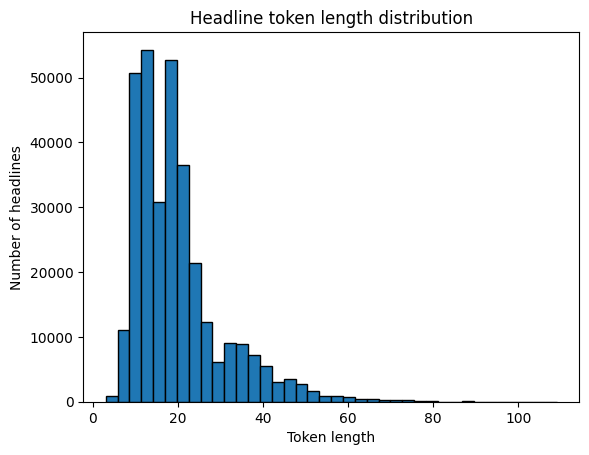

In [54]:
# checking what max_length parameter should be
encodings = tokenizer(
    list_headlines,
    padding=False,
    truncation=False,
    add_special_tokens=True
)

lengths = [len(ids) for ids in encodings["input_ids"]]

print("Max length:", max(lengths))
print("Mean length:", sum(lengths) / len(lengths))
print("95th percentile:", sorted(lengths)[int(0.95 * len(lengths))])

plt.hist(lengths, bins=38, edgecolor='k')
plt.xlabel("Token length")
plt.ylabel("Number of headlines")
plt.title("Headline token length distribution")
plt.show()

In [55]:
lengths = [len(tokenizer.tokenize(t)) for t in list_headlines]
trunc_rate = sum(l > 64 for l in lengths) / len(lengths)

trunc_rate

0.003997671379645629

In [57]:
import time
import numpy as np

sample = list_headlines[:5000]

t0 = time.time()
_ = finbert(sample, batch_size=32, truncation=True, padding=True, max_length=64)
t1 = time.time()

secs = t1 - t0
print("seconds for 5k:", secs)
print("headlines/sec:", 5000 / secs)

# estimate full run
n = len(list_headlines)
print("estimated minutes:", (n / (5000 / secs)) / 60)


seconds for 5k: 147.70164847373962
headlines/sec: 33.85202569955722
estimated minutes: 158.99491651604177


In [58]:
finbert_results = finbert(
    list_headlines,
    batch_size=32,
    truncation=True,
    padding=True,
    max_length=64
)


In [59]:
id2label = model.config.id2label
labels = [id2label[i].lower() for i in range(len(id2label))]  # e.g. ['positive','negative','neutral']


In [60]:
# map each headline’s list-of-dicts to a dict {label: score}
per_row = []
for row in finbert_results:
    d = {item['label'].lower(): item['score'] for item in row}
    per_row.append(d)

scores_df = pd.DataFrame(per_row)

In [61]:
for col in ["positive", "neutral", "negative"]:
    if col not in scores_df.columns:
        scores_df[col] = np.nan
        
scores_df = scores_df[["positive", "neutral", "negative"]]

In [62]:
scores_df["finbert_label"] = scores_df[["positive", "neutral", "negative"]].idxmax(axis=1)
scores_df["finbert_confidence"] = scores_df[["positive", "neutral", "negative"]].max(axis=1)


In [63]:
news_finbert = finbert_input.reset_index(drop=True).join(scores_df)


In [64]:
df = df.merge(
    news_finbert[
        ["title", "timestamp_et", "stock",
         "positive", "neutral", "negative",
         "finbert_label", "finbert_confidence"]
    ],
    on=["title", "timestamp_et", "stock"],
    how="left"
)

df.head(15)

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,AbsReturn_next_day,Sign_next_day,HighVol_next_day,abs_ret_t,vol_5,positive,neutral,negative,finbert_label,finbert_confidence
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,0.012676,1,0,0.056474,NaN,0.156559,0.797031,0.046411,neutral,0.797031
1,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,0.034872,1,1,0.035034,NaN,0.386939,0.569714,0.043347,neutral,0.569714
2,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,0.053446,1,1,0.005144,NaN,0.511469,0.471725,0.016806,positive,0.511469
3,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,0.030955,1,1,0.002587,NaN,0.061889,0.915127,0.022984,neutral,0.915127
4,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,0.026836,0,1,0.009143,0.021677,0.064593,0.896044,0.039362,neutral,0.896044
5,Brampton Brick Reports Results for the Second ...,2009-08-06 21:48:00-04:00,A,NYSE,2009-08-06 21:48:00-04:00,21:48:00,2009-08-06,overnight,Health Care,True,...,0.019575,1,0,0.011112,0.012604,0.031107,0.870270,0.098623,neutral,0.870270
6,Pengrowth Energy Trust Announces Second Quarte...,2009-08-06 21:21:00-04:00,A,NYSE,2009-08-06 21:21:00-04:00,21:21:00,2009-08-06,overnight,Health Care,True,...,0.019575,1,0,0.011112,0.007820,0.034638,0.906703,0.058659,neutral,0.906703
7,Supertel Hospitality Reports 2009 Second Quart...,2009-08-06 20:43:00-04:00,A,NYSE,2009-08-06 20:43:00-04:00,20:43:00,2009-08-06,overnight,Health Care,True,...,0.019575,1,0,0.011112,0.009013,0.054065,0.898251,0.047683,neutral,0.898251
8,SRS Class Action Lawsuit filed 08/05/2009,2009-08-06 14:40:00-04:00,A,NYSE,2009-08-06 14:40:00-04:00,14:40:00,2009-08-06,intraday,Health Care,True,...,0.019575,1,0,0.011112,0.010718,0.025124,0.364386,0.610490,negative,0.610490
9,C.A. Bancorp Inc. Reports Second Quarter 2009 ...,2009-08-07 15:56:00-04:00,A,NYSE,2009-08-07 15:56:00-04:00,15:56:00,2009-08-07,intraday,Health Care,True,...,0.004205,1,0,0.019575,0.012804,0.051462,0.790982,0.157556,neutral,0.790982


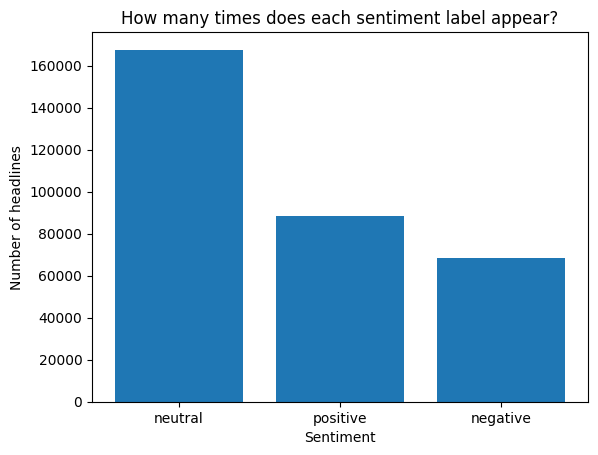

In [65]:
label_counts = df["finbert_label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.title("How many times does each sentiment label appear?")
plt.xlabel("Sentiment")
plt.ylabel("Number of headlines")
plt.show()

In [66]:
df.to_csv("../data/preprocessed/separate_stocks_finbert.csv", index=False)
df.to_parquet("../data/preprocessed/separate_stocks_finbert.parquet", index=False)